In [2]:
# =========================
# BLOCK 0: Security + Config
# =========================
import os, json, time, hashlib, sqlite3, random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

# Hardcoded API key
OPENAI_API_KEY = ""

@dataclass
class CFG:
    # Input files
    validation_path: str = "modded_s2orc_validation.jsonl"
    ml_unlabeled_path: str = "modded_s2orc_ml.jsonl"
    nonml_unlabeled_path: str = "modded_s2orc_nonml.jsonl"

    # Storage
    root: Path = Path("./observatory_run")
    bronze_dir: Path = Path("./observatory_run/data/bronze")
    silver_dir: Path = Path("./observatory_run/data/silver")
    metrics_dir: Path = Path("./observatory_run/metrics")
    preds_dir: Path = Path("./observatory_run/preds")
    cache_dir: Path = Path("./observatory_run/cache")
    sqlite_path: Path = Path("./observatory_run/cache/cache.sqlite")

    # Models (OpenAI)
    llm_model: str = "gpt-4o-mini"
    llm_strong_model: str = "gpt-4o"
    embed_model: str = "text-embedding-3-large"

    # Run params
    seed: int = 42
    max_text_chars: int = 12000  # avoid huge calls; trim safely

cfg = CFG()

# Create folders
for p in [cfg.bronze_dir, cfg.silver_dir, cfg.metrics_dir, cfg.preds_dir, cfg.cache_dir]:
    p.mkdir(parents=True, exist_ok=True)

# Reproducibility
random.seed(cfg.seed)
np.random.seed(cfg.seed)

# SQLite cache (for embeddings + LLM outputs)
con = sqlite3.connect(cfg.sqlite_path)
cur = con.cursor()
cur.execute("""
CREATE TABLE IF NOT EXISTS embeddings_cache (
  key TEXT PRIMARY KEY,
  model TEXT,
  paper_id TEXT,
  text_hash TEXT,
  created_at REAL,
  dim INTEGER,
  vector BLOB
)
""")
cur.execute("""
CREATE TABLE IF NOT EXISTS llm_cache (
  key TEXT PRIMARY KEY,
  model TEXT,
  paper_id TEXT,
  text_hash TEXT,
  created_at REAL,
  json TEXT
)
""")
con.commit()
con.close()

print("✅ Block 0 ready.")
print("Run folder:", cfg.root.resolve())
print("Embedding model:", cfg.embed_model)
print("LLM model:", cfg.llm_model)


✅ Block 0 ready.
Run folder: /observatory_run
Embedding model: text-embedding-3-large
LLM model: gpt-4o-mini


In [3]:
# =========================
# BLOCK 1: Streaming Ingestion -> Bronze Layer (3 datasets preserved)
# =========================
import re
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

try:
    import pyarrow as pa
    import pyarrow.parquet as pq
except Exception as e:
    raise RuntimeError("pyarrow is required. Run: pip install pyarrow") from e


# ---------- helpers ----------
def _safe_str(x):
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    return str(x)

def normalize_field(x):
    s = _safe_str(x).strip()
    return s if s else "Unknown"

def parse_year(pub_date) -> int:
    """
    Validation has publication_date as object/string.
    Unlabeled has publication_date int64.
    """
    if pub_date is None:
        return -1
    if isinstance(pub_date, (int, np.integer)):
        y = int(pub_date)
        return y if 1500 <= y <= 2100 else -1
    s = _safe_str(pub_date).strip()
    m = re.search(r"(19\d{2}|20\d{2})", s)
    if not m:
        return -1
    y = int(m.group(1))
    return y if 1500 <= y <= 2100 else -1

def clip_text(s: str, max_chars: int) -> str:
    s = _safe_str(s)
    return s if len(s) <= max_chars else s[:max_chars]

def write_partitioned_parquet(df: pd.DataFrame, out_root: Path, partition_cols=("field", "publication_year"), base_name="part"):
    out_root.mkdir(parents=True, exist_ok=True)
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_to_dataset(
        table,
        root_path=str(out_root),
        partition_cols=list(partition_cols),
        basename_template=f"{base_name}-{{i}}.parquet",
        existing_data_behavior="overwrite_or_ignore"
    )

def stream_jsonl(path: str, chunksize: int):
    return pd.read_json(path, lines=True, chunksize=chunksize)


# ---------- output roots ----------
bronze_root = cfg.bronze_dir
val_out = bronze_root / "validation_eval"
ml_out = bronze_root / "ml_unlabeled"
nonml_out = bronze_root / "nonml_unlabeled"
unlabeled_all_out = bronze_root / "unlabeled_all"

# wipe old (deterministic runs)
for p in [val_out, ml_out, nonml_out, unlabeled_all_out]:
    if p.exists():
        shutil.rmtree(p)

print("============================================================")
print("BLOCK 1: BUILD BRONZE LAYER (VALIDATION + ML + NONML)")
print("============================================================")


BLOCK 1: BUILD BRONZE LAYER (VALIDATION + ML + NONML)


In [4]:
# ============================================================
# 1A) Validation dataset (keep nested structs exactly)
# ============================================================
print("\n[1A] Validation -> bronze/validation_eval (partitioned)")
val_cols = [
    "paper_id", "field", "publication_date",
    "ml_adoption", "reproducibility", "research_outcomes", "impact_indicators",
    "overall_assessment", "confidence_score", "notes", "success"
]

val_rows = 0
for i, chunk in enumerate(stream_jsonl(cfg.validation_path, chunksize=2000)):
    present = [c for c in val_cols if c in chunk.columns]
    chunk = chunk[present].copy()

    # Normalize columns
    chunk["paper_id"] = chunk["paper_id"].astype(str)
    chunk["field"] = chunk["field"].apply(normalize_field)

    # Keep original date and derive year
    chunk["publication_year"] = chunk["publication_date"].apply(parse_year).astype(int)

    # Create evaluator text (explicitly labeled)
    oa = chunk["overall_assessment"].apply(_safe_str) if "overall_assessment" in chunk.columns else ""
    nt = chunk["notes"].apply(_safe_str) if "notes" in chunk.columns else ""
    chunk["eval_text"] = (oa + " " + nt).map(lambda x: clip_text(x, cfg.max_text_chars))

    # Tags
    chunk["split"] = "validation"
    chunk["text_kind"] = "evaluator_summary"
    chunk["is_ml_seed"] = np.nan  # not applicable

    # Write
    write_partitioned_parquet(
        chunk,
        val_out,
        partition_cols=("field", "publication_year"),
        base_name=f"validation_{i:05d}"
    )
    val_rows += len(chunk)

print(f"✅ Validation rows written: {val_rows:,} -> {val_out}")



[1A] Validation -> bronze/validation_eval (partitioned)
✅ Validation rows written: 7,200 -> observatory_run/data/bronze/validation_eval


In [5]:
# ============================================================
# 1B) ML unlabeled dataset (raw paper text)
# ============================================================
print("\n[1B] ML unlabeled -> bronze/ml_unlabeled (partitioned)")
ml_rows = 0
for i, chunk in enumerate(stream_jsonl(cfg.ml_unlabeled_path, chunksize=5000)):
    # Expected schema: id, text, field, publication_date (int64), matched_term
    chunk = chunk.copy()

    chunk["paper_id"] = chunk["id"].astype(str)
    chunk["field"] = chunk["field"].apply(normalize_field)
    chunk["publication_year"] = chunk["publication_date"].apply(parse_year).astype(int)
    chunk["text"] = chunk["text"].map(lambda x: clip_text(_safe_str(x), cfg.max_text_chars))
    if "matched_term" not in chunk.columns:
        chunk["matched_term"] = None

    chunk["split"] = "ml_unlabeled"
    chunk["text_kind"] = "paper_text"
    chunk["is_ml_seed"] = 1  # seed label ONLY for analysis (not ground truth)

    out = chunk[["paper_id","field","publication_date","publication_year","text","matched_term","split","text_kind","is_ml_seed"]].copy()

    write_partitioned_parquet(
        out,
        ml_out,
        partition_cols=("field", "publication_year"),
        base_name=f"ml_{i:05d}"
    )
    ml_rows += len(out)

print(f"✅ ML unlabeled rows written: {ml_rows:,} -> {ml_out}")



[1B] ML unlabeled -> bronze/ml_unlabeled (partitioned)
✅ ML unlabeled rows written: 3,739 -> observatory_run/data/bronze/ml_unlabeled


In [6]:
# ============================================================
# 1C) Non-ML unlabeled dataset (raw paper text)
# ============================================================
print("\n[1C] Non-ML unlabeled -> bronze/nonml_unlabeled (partitioned)")
nonml_rows = 0
for i, chunk in enumerate(stream_jsonl(cfg.nonml_unlabeled_path, chunksize=8000)):
    chunk = chunk.copy()

    chunk["paper_id"] = chunk["id"].astype(str)
    chunk["field"] = chunk["field"].apply(normalize_field)
    chunk["publication_year"] = chunk["publication_date"].apply(parse_year).astype(int)
    chunk["text"] = chunk["text"].map(lambda x: clip_text(_safe_str(x), cfg.max_text_chars))

    chunk["matched_term"] = None  # doesn't exist here
    chunk["split"] = "nonml_unlabeled"
    chunk["text_kind"] = "paper_text"
    chunk["is_ml_seed"] = 0  # seed label ONLY for analysis (not ground truth)

    out = chunk[["paper_id","field","publication_date","publication_year","text","matched_term","split","text_kind","is_ml_seed"]].copy()

    write_partitioned_parquet(
        out,
        nonml_out,
        partition_cols=("field", "publication_year"),
        base_name=f"nonml_{i:05d}"
    )
    nonml_rows += len(out)

print(f"✅ Non-ML unlabeled rows written: {nonml_rows:,} -> {nonml_out}")




[1C] Non-ML unlabeled -> bronze/nonml_unlabeled (partitioned)
✅ Non-ML unlabeled rows written: 25,882 -> observatory_run/data/bronze/nonml_unlabeled


In [8]:
# ============================================================
# 1D) Create merged unlabeled view (for inference & dashboard) - FIXED
# ============================================================
print("\n[1D] Merge unlabeled -> bronze/unlabeled_all (partitioned) [FIXED]")

import re

def extract_partitions_from_path(fp: Path):
    """
    Given a path like .../field=Physics/publication_year=2022/xxx.parquet
    return ("Physics", 2022)
    """
    s = str(fp)
    m_field = re.search(r"/field=([^/]+)/", s)
    m_year  = re.search(r"/publication_year=([^/]+)/", s)
    field = m_field.group(1) if m_field else "Unknown"
    year = int(m_year.group(1)) if m_year else -1
    return field, year

def iter_parquet_files(root: Path):
    return list(root.rglob("*.parquet"))

# Recreate output folder
if unlabeled_all_out.exists():
    shutil.rmtree(unlabeled_all_out)

ml_files = iter_parquet_files(ml_out)
nonml_files = iter_parquet_files(nonml_out)

merged_rows = 0
all_files = [("ml_unlabeled", ml_files), ("nonml_unlabeled", nonml_files)]

for tag, files in all_files:
    for j, fp in enumerate(files):
        dfp = pd.read_parquet(fp)

        # Re-add partition columns if missing
        if "field" not in dfp.columns or "publication_year" not in dfp.columns:
            f, y = extract_partitions_from_path(fp)
            if "field" not in dfp.columns:
                dfp["field"] = f
            if "publication_year" not in dfp.columns:
                dfp["publication_year"] = y

        # Write partitioned
        write_partitioned_parquet(
            dfp,
            unlabeled_all_out,
            partition_cols=("field", "publication_year"),
            base_name=f"{tag}_{j:05d}"
        )
        merged_rows += len(dfp)

print(f"✅ Unlabeled merged rows written: {merged_rows:,} -> {unlabeled_all_out}")



[1D] Merge unlabeled -> bronze/unlabeled_all (partitioned) [FIXED]
✅ Unlabeled merged rows written: 29,621 -> observatory_run/data/bronze/unlabeled_all


In [9]:
# ============================================================
# 1E) SANITY CHECKS – BRONZE LAYER
# ============================================================
print("\n============================================================")
print("BLOCK 1E: SANITY CHECKS (BRONZE LAYER)")
print("============================================================")

import re

def extract_partitions_from_path(fp: Path):
    s = str(fp)
    m_field = re.search(r"/field=([^/]+)/", s)
    m_year  = re.search(r"/publication_year=([^/]+)/", s)
    field = m_field.group(1) if m_field else "Unknown"
    year = int(m_year.group(1)) if m_year else -1
    return field, year

def read_sample(root: Path, n_files=3, n_rows=5):
    files = list(root.rglob("*.parquet"))
    if not files:
        print(f"❌ No parquet files found in {root}")
        return

    print(f"\n📂 Sampling from {root}")
    for fp in files[:n_files]:
        df = pd.read_parquet(fp)

        # Reconstruct partition columns if needed
        if "field" not in df.columns or "publication_year" not in df.columns:
            f, y = extract_partitions_from_path(fp)
            if "field" not in df.columns:
                df["field"] = f
            if "publication_year" not in df.columns:
                df["publication_year"] = y

        print(f"\n🧪 File: {fp}")
        print("   Columns:", list(df.columns))
        print(df.head(n_rows))

def quick_counts(root: Path, label: str):
    files = list(root.rglob("*.parquet"))
    total = 0
    for fp in files:
        df = pd.read_parquet(fp)
        total += len(df)
    print(f"✅ {label}: {total:,} rows across {len(files)} parquet files")

# -------------------------
# Validation sanity check
# -------------------------
print("\n-------------------------")
print("VALIDATION DATASET CHECK")
print("-------------------------")
quick_counts(val_out, "Validation")
read_sample(val_out)

# -------------------------
# ML unlabeled sanity check
# -------------------------
print("\n-------------------------")
print("ML UNLABELED DATASET CHECK")
print("-------------------------")
quick_counts(ml_out, "ML Unlabeled")
read_sample(ml_out)

# -------------------------
# Non-ML unlabeled sanity check
# -------------------------
print("\n-------------------------")
print("NON-ML UNLABELED DATASET CHECK")
print("-------------------------")
quick_counts(nonml_out, "Non-ML Unlabeled")
read_sample(nonml_out)

# -------------------------
# Merged unlabeled sanity check
# -------------------------
print("\n-------------------------")
print("MERGED UNLABELED DATASET CHECK")
print("-------------------------")
quick_counts(unlabeled_all_out, "Merged Unlabeled")
read_sample(unlabeled_all_out)

print("\n============================================================")
print("✅ BLOCK 1E COMPLETE – BRONZE LAYER VERIFIED")
print("============================================================")



BLOCK 1E: SANITY CHECKS (BRONZE LAYER)

-------------------------
VALIDATION DATASET CHECK
-------------------------
✅ Validation: 7,200 rows across 56 parquet files

📂 Sampling from observatory_run/data/bronze/validation_eval

🧪 File: observatory_run/data/bronze/validation_eval/field=Business/publication_year=2018/validation_00003-0.parquet
   Columns: ['paper_id', 'publication_date', 'ml_adoption', 'reproducibility', 'research_outcomes', 'impact_indicators', 'overall_assessment', 'confidence_score', 'notes', 'success', 'eval_text', 'split', 'text_kind', 'is_ml_seed', 'field', 'publication_year']
    paper_id  publication_date  \
0  116758210              2018   
1    4502216              2018   
2  149133726              2018   
3   55750985              2018   
4   49552663              2018   

                                         ml_adoption  \
0  {'compute_resources_mentioned': [], 'datasets_...   
1  {'compute_resources_mentioned': [], 'datasets_...   
2  {'compute_resource

In [10]:
# =========================
# BLOCK 2: Extract Ground-Truth Labels (Validation) -> Silver
# =========================
import pandas as pd
import numpy as np
from pathlib import Path

# Paths
val_bronze_root = cfg.bronze_dir / "validation_eval"
val_silver_out = cfg.silver_dir / "validation_labels.parquet"

print("============================================================")
print("BLOCK 2: LABEL EXTRACTION (VALIDATION -> SILVER)")
print("============================================================")
print("Reading from:", val_bronze_root)

# Load entire validation (7200 rows, so safe in RAM)
# NOTE: This will materialize partition cols too (field/publication_year) because we wrote them into files in Block 1.
val_df = pd.read_parquet(val_bronze_root)
print("Loaded validation rows:", len(val_df))
print("Columns:", list(val_df.columns))

# -------------------------
# Label mappings (exact ordinal scales)
# -------------------------
ADOPTION_MAP = {
    "none": 0,
    "minimal": 1,
    "moderate": 2,
    "substantial": 3,
    "core": 4
}

IMPACT_SCOPE_MAP = {
    "narrow": 0,
    "moderate": 1,
    "broad": 2,
    "transformative": 3
}

REPRO_MAP = {
    "not_feasible": 0,
    "difficult": 1,
    "moderate": 2,
    "straightforward": 3
}

def safe_get(d, key, default=None):
    if isinstance(d, dict):
        return d.get(key, default)
    return default

def normalize_label(s):
    if s is None:
        return None
    s = str(s).strip()
    if not s:
        return None
    return s.lower()

# -------------------------
# Extract raw label strings from nested structs
# -------------------------
val_df["adoption_str"] = val_df["ml_adoption"].apply(lambda d: normalize_label(safe_get(d, "ml_adoption_level")))
val_df["impact_str"] = val_df["impact_indicators"].apply(lambda d: normalize_label(safe_get(d, "potential_impact_scope")))
val_df["repro_str"] = val_df["reproducibility"].apply(lambda d: normalize_label(safe_get(d, "replication_feasibility")))

# Map to ordinal ints
val_df["y_adoption_level"] = val_df["adoption_str"].map(ADOPTION_MAP).astype("Int64")
val_df["y_impact_scope"] = val_df["impact_str"].map(IMPACT_SCOPE_MAP).astype("Int64")
val_df["y_reproducibility"] = val_df["repro_str"].map(REPRO_MAP).astype("Int64")

# Define binary ML label from adoption level (ground truth)
val_df["y_is_ml"] = (val_df["y_adoption_level"].fillna(0) > 0).astype(int)

# -------------------------
# Filter to success==True (recommended for judging alignment)
# -------------------------
before = len(val_df)
if "success" in val_df.columns:
    val_df = val_df[val_df["success"] == True].copy()
after = len(val_df)
print(f"\nFiltered success==True: {before} -> {after}")

# Drop rows where any label is missing (keep it strict)
label_cols = ["y_adoption_level", "y_impact_scope", "y_reproducibility"]
missing_any = val_df[label_cols].isna().any(axis=1).sum()
print("Rows missing any target label:", int(missing_any))

val_df = val_df[~val_df[label_cols].isna().any(axis=1)].copy()
print("Rows kept after dropping missing labels:", len(val_df))

# -------------------------
# Judge-friendly class imbalance report
# -------------------------
def dist_report(series, name, inv_map=None):
    vc = series.value_counts(dropna=False).sort_index()
    total = vc.sum()
    print(f"\n📊 Distribution: {name} (n={total})")
    for k, v in vc.items():
        pct = 100 * v / total if total else 0
        label = inv_map.get(k, k) if inv_map else k
        print(f"  {label}: {v} ({pct:.2f}%)")

INV_ADOPTION = {v: k for k, v in ADOPTION_MAP.items()}
INV_IMPACT = {v: k for k, v in IMPACT_SCOPE_MAP.items()}
INV_REPRO = {v: k for k, v in REPRO_MAP.items()}

dist_report(val_df["y_is_ml"], "y_is_ml (binary)")
dist_report(val_df["y_adoption_level"], "y_adoption_level (0–4)", INV_ADOPTION)
dist_report(val_df["y_impact_scope"], "y_impact_scope (0–3)", INV_IMPACT)
dist_report(val_df["y_reproducibility"], "y_reproducibility (0–3)", INV_REPRO)

# -------------------------
# Minimal training frame saved to silver
# - Keep eval_text (evaluator summary) for now; later we will train on paper text embeddings for unlabeled.
# -------------------------
keep_cols = [
    "paper_id", "field", "publication_date", "publication_year",
    "eval_text",
    "ml_adoption", "reproducibility", "research_outcomes", "impact_indicators",
    "y_is_ml", "y_adoption_level", "y_impact_scope", "y_reproducibility",
    "confidence_score", "notes"
]
keep_cols = [c for c in keep_cols if c in val_df.columns]

val_df_out = val_df[keep_cols].copy()

# Write silver parquet
val_silver_out.parent.mkdir(parents=True, exist_ok=True)
val_df_out.to_parquet(val_silver_out, index=False)
print("\n✅ Wrote silver labels to:", val_silver_out)
print("Silver shape:", val_df_out.shape)


BLOCK 2: LABEL EXTRACTION (VALIDATION -> SILVER)
Reading from: observatory_run/data/bronze/validation_eval
Loaded validation rows: 7200
Columns: ['paper_id', 'publication_date', 'ml_adoption', 'reproducibility', 'research_outcomes', 'impact_indicators', 'overall_assessment', 'confidence_score', 'notes', 'success', 'eval_text', 'split', 'text_kind', 'is_ml_seed', 'field', 'publication_year']

Filtered success==True: 7200 -> 7200
Rows missing any target label: 0
Rows kept after dropping missing labels: 7200

📊 Distribution: y_is_ml (binary) (n=7200)
  0: 6279 (87.21%)
  1: 921 (12.79%)

📊 Distribution: y_adoption_level (0–4) (n=7200)
  none: 6279 (87.21%)
  minimal: 659 (9.15%)
  moderate: 165 (2.29%)
  substantial: 31 (0.43%)
  core: 66 (0.92%)

📊 Distribution: y_impact_scope (0–3) (n=7200)
  narrow: 2057 (28.57%)
  moderate: 4764 (66.17%)
  broad: 375 (5.21%)
  transformative: 4 (0.06%)

📊 Distribution: y_reproducibility (0–3) (n=7200)
  not_feasible: 314 (4.36%)
  difficult: 924 (12.8

In [18]:
# =========================
# BLOCK 3 (ENV-SAFE): TEXT FEATURES -> 256D
# CPU HashingVectorizer (scales, no vocab fit)
# CPU TruncatedSVD (fast enough for 36k docs)
# Saves same artifacts as before:
#   cache/features/validation_X_256.npy
#   cache/features/unlabeled_X_256.npy
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

print("============================================================")
print("BLOCK 3 (ENV-SAFE): CPU HASHING TF-IDF -> SVD (256D)")
print("============================================================")

feat_dir = cfg.cache_dir / "features"
feat_dir.mkdir(parents=True, exist_ok=True)

X_val_path = feat_dir / "validation_X_256.npy"
X_unl_path = feat_dir / "unlabeled_X_256.npy"
meta_val_path = feat_dir / "validation_meta.parquet"
meta_unl_path = feat_dir / "unlabeled_meta.parquet"

# -------------------------
# Load inputs
# -------------------------
val_path = cfg.silver_dir / "validation_labels.parquet"
unl_root = cfg.bronze_dir / "unlabeled_all"

val_df = pd.read_parquet(val_path)
unl_df = pd.read_parquet(unl_root)

print("Validation loaded:", val_df.shape)
print("Unlabeled loaded:", unl_df.shape)

# Text source
val_text = val_df["eval_text"].fillna("").astype(str)
unl_text = unl_df["text"].fillna("").astype(str)

# Save metadata for join later
val_meta = val_df[["paper_id", "field", "publication_year",
                   "y_is_ml", "y_adoption_level", "y_impact_scope", "y_reproducibility"]].copy()
unl_meta = unl_df[["paper_id", "field", "publication_year",
                   "split", "is_ml_seed", "matched_term"]].copy()

val_meta.to_parquet(meta_val_path, index=False)
unl_meta.to_parquet(meta_unl_path, index=False)

print("✅ Wrote meta files:")
print(" -", meta_val_path)
print(" -", meta_unl_path)

# -------------------------
# Feature params
# -------------------------
N_FEATURES = 2**18     # 262,144 hashed features
NGRAM_RANGE = (1, 2)
SVD_DIM = 256

# -------------------------
# CPU Hashing TF-IDF
# -------------------------
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import vstack

print("\n🔹 [CPU] HashingVectorizer -> counts")
hv = HashingVectorizer(
    n_features=N_FEATURES,
    alternate_sign=False,
    norm=None,               # tf-idf handles normalization
    ngram_range=NGRAM_RANGE,
    binary=False,
    lowercase=True
)

X_val_counts = hv.transform(val_text.tolist())
X_unl_counts = hv.transform(unl_text.tolist())

print("   counts val:", X_val_counts.shape, "nnz:", int(X_val_counts.nnz))
print("   counts unl:", X_unl_counts.shape, "nnz:", int(X_unl_counts.nnz))

print("\n🔹 [CPU] TF-IDF transform (fit on combined)")
tfidf = TfidfTransformer(norm="l2")
X_stack_counts = vstack([X_val_counts, X_unl_counts])
tfidf.fit(X_stack_counts)

X_val_tfidf = tfidf.transform(X_val_counts)
X_unl_tfidf = tfidf.transform(X_unl_counts)

print("   tfidf val:", X_val_tfidf.shape, "nnz:", int(X_val_tfidf.nnz))
print("   tfidf unl:", X_unl_tfidf.shape, "nnz:", int(X_unl_tfidf.nnz))

print("\n🔹 [CPU] TruncatedSVD -> 256D (fit on combined)")
X_stack_tfidf = vstack([X_val_tfidf, X_unl_tfidf])
svd = TruncatedSVD(n_components=SVD_DIM, random_state=cfg.seed)
svd.fit(X_stack_tfidf)

X_val_256 = svd.transform(X_val_tfidf).astype(np.float32)
X_unl_256 = svd.transform(X_unl_tfidf).astype(np.float32)

print("\nFeature shapes:")
print(" - X_val_256:", X_val_256.shape, X_val_256.dtype)
print(" - X_unl_256:", X_unl_256.shape, X_unl_256.dtype)

np.save(X_val_path, X_val_256)
np.save(X_unl_path, X_unl_256)

print("\n✅ Saved feature matrices:")
print(" -", X_val_path)
print(" -", X_unl_path)

print("\n✅ BLOCK 3 COMPLETE")


BLOCK 3 (ENV-SAFE): CPU HASHING TF-IDF -> SVD (256D)
Validation loaded: (7200, 15)
Unlabeled loaded: (29621, 9)
✅ Wrote meta files:
 - observatory_run/cache/features/validation_meta.parquet
 - observatory_run/cache/features/unlabeled_meta.parquet

🔹 [CPU] HashingVectorizer -> counts
   counts val: (7200, 262144) nnz: 1415710
   counts unl: (29621, 262144) nnz: 54577866

🔹 [CPU] TF-IDF transform (fit on combined)
   tfidf val: (7200, 262144) nnz: 1415710
   tfidf unl: (29621, 262144) nnz: 54577866

🔹 [CPU] TruncatedSVD -> 256D (fit on combined)

Feature shapes:
 - X_val_256: (7200, 256) float32
 - X_unl_256: (29621, 256) float32

✅ Saved feature matrices:
 - observatory_run/cache/features/validation_X_256.npy
 - observatory_run/cache/features/unlabeled_X_256.npy

✅ BLOCK 3 COMPLETE


In [20]:
# =========================
# BLOCK 4: TRAIN + EVAL + INFER (SILVER PREDICTIONS)
# Trains models on validation_X_256 to predict:
#   - y_is_ml (binary)
#   - y_adoption_level (5-class)
#   - y_impact_scope (4-class)
#   - y_reproducibility (4-class)
# Outputs:
#   - silver/validation_pred_debug.parquet (for audits)
#   - silver/unlabeled_predictions.parquet (main output)
# =========================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

print("============================================================")
print("BLOCK 4: TRAIN + EVAL + INFER -> SILVER PREDICTIONS")
print("============================================================")

# Paths
feat_dir = cfg.cache_dir / "features"
silver_dir = cfg.silver_dir
silver_dir.mkdir(parents=True, exist_ok=True)

X_val = np.load(feat_dir / "validation_X_256.npy")
X_unl = np.load(feat_dir / "unlabeled_X_256.npy")

val_meta = pd.read_parquet(feat_dir / "validation_meta.parquet")
unl_meta = pd.read_parquet(feat_dir / "unlabeled_meta.parquet")

print("X_val:", X_val.shape, X_val.dtype)
print("X_unl:", X_unl.shape, X_unl.dtype)
print("val_meta:", val_meta.shape)
print("unl_meta:", unl_meta.shape)

# Targets
y_is_ml = val_meta["y_is_ml"].astype(int).values
y_adopt = val_meta["y_adoption_level"].astype(int).values
y_impact = val_meta["y_impact_scope"].astype(int).values
y_repro = val_meta["y_reproducibility"].astype(int).values

# Split once, reuse indices for all tasks (keeps evaluation comparable)
idx = np.arange(len(X_val))
idx_train, idx_test = train_test_split(
    idx, test_size=0.2, random_state=cfg.seed, stratify=y_is_ml
)
X_tr, X_te = X_val[idx_train], X_val[idx_test]

def train_calibrated_lr(X_tr, y_tr, X_te, y_te, label: str):
    """
    LogisticRegression + probability calibration (sigmoid).

    Notes:
    - Compatible with newer sklearn where `multi_class` kw may be removed.
    - LBFGS handles multinomial automatically when y has >2 classes.
    - Calibration makes confidence values meaningful.
    """
    base = LogisticRegression(
        max_iter=4000,
        class_weight="balanced",
        solver="lbfgs"
    )

    clf = CalibratedClassifierCV(base, method="sigmoid", cv=3)
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_te)
    proba = clf.predict_proba(X_te)

    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average="macro")
    f1w = f1_score(y_te, y_pred, average="weighted")
    cm = confusion_matrix(y_te, y_pred)

    print("\n--------------------------------------")
    print(f"Task: {label}")
    print("--------------------------------------")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1:  {f1m:.4f}   (judge cares: handles imbalance)")
    print(f"Weighted-F1:{f1w:.4f}")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_te, y_pred, digits=4))

    return clf

# Train 4 tasks
clf_is_ml = train_calibrated_lr(
    X_tr, y_is_ml[idx_train], X_te, y_is_ml[idx_test], "y_is_ml (binary)"
)
clf_adopt = train_calibrated_lr(
    X_tr, y_adopt[idx_train], X_te, y_adopt[idx_test], "y_adoption_level (0-4)"
)
clf_impact = train_calibrated_lr(
    X_tr, y_impact[idx_train], X_te, y_impact[idx_test], "y_impact_scope (0-3)"
)
clf_repro = train_calibrated_lr(
    X_tr, y_repro[idx_train], X_te, y_repro[idx_test], "y_reproducibility (0-3)"
)

# -------------------------
# Infer on ALL validation + unlabeled
# -------------------------
def predict_with_confidence(clf, X, prefix: str):
    pred = clf.predict(X)
    proba = clf.predict_proba(X)
    conf = proba.max(axis=1)  # calibrated confidence
    out = pd.DataFrame({
        f"{prefix}_pred": pred,
        f"{prefix}_conf": conf.astype(np.float32)
    })
    return out, proba

print("\n🔹 Predicting on full validation + unlabeled ...")

val_is_ml, _ = predict_with_confidence(clf_is_ml, X_val, "is_ml")
val_adopt, _ = predict_with_confidence(clf_adopt, X_val, "adoption")
val_impact, _ = predict_with_confidence(clf_impact, X_val, "impact")
val_repro, _ = predict_with_confidence(clf_repro, X_val, "repro")

unl_is_ml, _ = predict_with_confidence(clf_is_ml, X_unl, "is_ml")
unl_adopt, _ = predict_with_confidence(clf_adopt, X_unl, "adoption")
unl_impact, _ = predict_with_confidence(clf_impact, X_unl, "impact")
unl_repro, _ = predict_with_confidence(clf_repro, X_unl, "repro")

# Join into debug validation table
val_pred_debug = pd.concat(
    [val_meta.reset_index(drop=True),
     val_is_ml, val_adopt, val_impact, val_repro],
    axis=1
)

# Join into main unlabeled predictions table
unl_pred = pd.concat(
    [unl_meta.reset_index(drop=True),
     unl_is_ml, unl_adopt, unl_impact, unl_repro],
    axis=1
)

# -------------------------
# Create an "overall confidence_score" like the dataset (low/medium/high)
# -------------------------
def bucket_conf(x: np.ndarray):
    out = np.full(len(x), "low", dtype=object)
    out[x >= 0.80] = "high"
    out[(x >= 0.60) & (x < 0.80)] = "medium"
    return out

val_pred_debug["overall_conf"] = (
    val_pred_debug["is_ml_conf"].values
    + val_pred_debug["adoption_conf"].values
    + val_pred_debug["impact_conf"].values
    + val_pred_debug["repro_conf"].values
) / 4.0
val_pred_debug["confidence_score_pred"] = bucket_conf(val_pred_debug["overall_conf"].values)

unl_pred["overall_conf"] = (
    unl_pred["is_ml_conf"].values
    + unl_pred["adoption_conf"].values
    + unl_pred["impact_conf"].values
    + unl_pred["repro_conf"].values
) / 4.0
unl_pred["confidence_score_pred"] = bucket_conf(unl_pred["overall_conf"].values)

# -------------------------
# Save outputs (persistent)
# -------------------------
val_out = silver_dir / "validation_pred_debug.parquet"
unl_out = silver_dir / "unlabeled_predictions.parquet"

val_pred_debug.to_parquet(val_out, index=False)
unl_pred.to_parquet(unl_out, index=False)

print("\n✅ Wrote:")
print(" -", val_out)
print(" -", unl_out)

print("\nPreview unlabeled predictions:")
print(unl_pred.head(3))

print("\n✅ BLOCK 4 COMPLETE")


BLOCK 4: TRAIN + EVAL + INFER -> SILVER PREDICTIONS
X_val: (7200, 256) float32
X_unl: (29621, 256) float32
val_meta: (7200, 7)
unl_meta: (29621, 6)

--------------------------------------
Task: y_is_ml (binary)
--------------------------------------
Accuracy: 0.9646
Macro-F1:  0.9173   (judge cares: handles imbalance)
Weighted-F1:0.9638
Confusion matrix:
 [[1239   17]
 [  34  150]]

Classification report:
               precision    recall  f1-score   support

           0     0.9733    0.9865    0.9798      1256
           1     0.8982    0.8152    0.8547       184

    accuracy                         0.9646      1440
   macro avg     0.9357    0.9008    0.9173      1440
weighted avg     0.9637    0.9646    0.9638      1440


--------------------------------------
Task: y_adoption_level (0-4)
--------------------------------------
Accuracy: 0.9174
Macro-F1:  0.5092   (judge cares: handles imbalance)
Weighted-F1:0.9031
Confusion matrix:
 [[1250    2    2    0    2]
 [  71   42   15   

/miniconda3/envs/nvidia_impact_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/miniconda3/envs/nvidia_impact_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/miniconda3/envs/nvidia_impact_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c


✅ Wrote:
 - observatory_run/data/silver/validation_pred_debug.parquet
 - observatory_run/data/silver/unlabeled_predictions.parquet

Preview unlabeled predictions:
   paper_id                        field  publication_year            split  \
0   2889327  AgriculturalAndFoodSciences              2016     ml_unlabeled   
1  99631507  AgriculturalAndFoodSciences              2016  nonml_unlabeled   
2  89848143  AgriculturalAndFoodSciences              2016  nonml_unlabeled   

   is_ml_seed    matched_term  is_ml_pred  is_ml_conf  adoption_pred  \
0           1  neural network           0    0.687027              0   
1           0            None           0    0.855917              0   
2           0            None           0    0.906837              0   

   adoption_conf  impact_pred  impact_conf  repro_pred  repro_conf  \
0       0.838351            1     0.748235           2    0.923996   
1       0.930593            1     0.714198           2    0.888950   
2       0.953162    

In [22]:
# =========================
# BLOCK 5: GOLD METRICS + ML IMPACT SCORE (paper + field/year)
# Inputs:
#   - silver/unlabeled_predictions.parquet
#   - silver/validation_pred_debug.parquet (optional for QA)
# Outputs:
#   - gold/paper_scores.parquet
#   - gold/field_year_metrics.parquet
#   - gold/field_metrics.parquet
# =========================

import numpy as np
import pandas as pd

print("============================================================")
print("BLOCK 5: GOLD METRICS + ML IMPACT SCORE")
print("============================================================")

silver_dir = cfg.silver_dir
# ✅ FIX: gold lives next to silver inside observatory_run/data/
gold_dir = cfg.silver_dir.parent / "gold"
gold_dir.mkdir(parents=True, exist_ok=True)

unl_path = silver_dir / "unlabeled_predictions.parquet"
valdbg_path = silver_dir / "validation_pred_debug.parquet"  # optional (not required below)

unl = pd.read_parquet(unl_path)
print("Loaded unlabeled predictions:", unl.shape)

# -------------------------
# Helpers
# -------------------------
def approx_pos_prob(pred: np.ndarray, conf: np.ndarray) -> np.ndarray:
    """
    We only stored (pred, max_conf). For binary tasks, approximate P(y=1):
      if pred==1 -> p ~= conf
      if pred==0 -> p ~= 1-conf
    """
    pred = pred.astype(int)
    conf = conf.astype(float)
    return np.where(pred == 1, conf, 1.0 - conf).clip(0.0, 1.0)

def normalize_class(x: np.ndarray, max_class: int) -> np.ndarray:
    x = x.astype(float)
    return (x / float(max_class)).clip(0.0, 1.0)

# -------------------------
# Paper-level score
# -------------------------
is_ml_p = approx_pos_prob(unl["is_ml_pred"].values, unl["is_ml_conf"].values)

adopt_norm  = normalize_class(unl["adoption_pred"].values, max_class=4)   # 0..4
impact_norm = normalize_class(unl["impact_pred"].values, max_class=3)     # 0..3
repro_norm  = normalize_class(unl["repro_pred"].values,  max_class=3)     # 0..3

# Two scores:
# 1) ML impact score (higher = more ML + higher impact + better reproducibility)
# 2) Repro risk (higher = more ML + lower reproducibility)
W_ADOPT, W_IMPACT, W_REPRO = 0.45, 0.35, 0.20

ml_impact_score = is_ml_p * (W_ADOPT * adopt_norm + W_IMPACT * impact_norm + W_REPRO * repro_norm)
repro_risk = is_ml_p * (1.0 - repro_norm)

paper_scores = unl.copy()
paper_scores["is_ml_prob"] = is_ml_p.astype(np.float32)
paper_scores["adoption_norm"] = adopt_norm.astype(np.float32)
paper_scores["impact_norm"] = impact_norm.astype(np.float32)
paper_scores["repro_norm"] = repro_norm.astype(np.float32)
paper_scores["ml_impact_score"] = ml_impact_score.astype(np.float32)
paper_scores["repro_risk"] = repro_risk.astype(np.float32)

# Dominant driver label (useful for dashboard explanations)
drivers = np.vstack([adopt_norm, impact_norm, repro_norm]).T
driver_names = np.array(["adoption", "impact", "repro"])
paper_scores["score_driver"] = driver_names[np.argmax(drivers, axis=1)]

# Persist
paper_out = gold_dir / "paper_scores.parquet"
paper_scores.to_parquet(paper_out, index=False)
print("✅ Wrote:", paper_out)

# -------------------------
# Field-year rollups (dashboard backbone)
# -------------------------
grp_cols = ["field", "publication_year"]

field_year = (
    paper_scores
    .groupby(grp_cols, dropna=False)
    .agg(
        n_papers=("paper_id", "size"),
        ml_share=("is_ml_prob", "mean"),
        avg_adoption=("adoption_pred", "mean"),
        avg_impact=("impact_pred", "mean"),
        avg_repro=("repro_pred", "mean"),
        avg_ml_impact=("ml_impact_score", "mean"),
        avg_repro_risk=("repro_risk", "mean"),
        p90_ml_impact=("ml_impact_score", lambda x: float(np.quantile(x, 0.90))),
        p99_ml_impact=("ml_impact_score", lambda x: float(np.quantile(x, 0.99))),
    )
    .reset_index()
)

field_year = field_year.sort_values(["field", "publication_year"])
field_year["ml_share_yoy"] = field_year.groupby("field")["ml_share"].diff()
field_year["avg_ml_impact_yoy"] = field_year.groupby("field")["avg_ml_impact"].diff()

fy_out = gold_dir / "field_year_metrics.parquet"
field_year.to_parquet(fy_out, index=False)
print("✅ Wrote:", fy_out)

# -------------------------
# Field-level summary (topline ranking)
# -------------------------
field_sum = (
    paper_scores
    .groupby("field", dropna=False)
    .agg(
        n_papers=("paper_id", "size"),
        ml_share=("is_ml_prob", "mean"),
        avg_ml_impact=("ml_impact_score", "mean"),
        p95_ml_impact=("ml_impact_score", lambda x: float(np.quantile(x, 0.95))),
        avg_repro_risk=("repro_risk", "mean"),
    )
    .reset_index()
    .sort_values(["avg_ml_impact", "ml_share", "n_papers"], ascending=False)
)

field_out = gold_dir / "field_metrics.parquet"
field_sum.to_parquet(field_out, index=False)
print("✅ Wrote:", field_out)

print("\nTop 10 fields by avg_ml_impact:")
print(field_sum.head(10)[["field","n_papers","ml_share","avg_ml_impact","avg_repro_risk"]])

print("\n✅ BLOCK 5 COMPLETE")


BLOCK 5: GOLD METRICS + ML IMPACT SCORE
Loaded unlabeled predictions: (29621, 16)
✅ Wrote: observatory_run/data/gold/paper_scores.parquet
✅ Wrote: observatory_run/data/gold/field_year_metrics.parquet
✅ Wrote: observatory_run/data/gold/field_metrics.parquet

Top 10 fields by avg_ml_impact:
                   field  n_papers  ml_share  avg_ml_impact  avg_repro_risk
4        ComputerScience      2984  0.348373       0.124854        0.116124
13               Physics      2804  0.250976       0.063367        0.083659
7            Engineering      1174  0.218564       0.055440        0.072855
10           Mathematics      1394  0.215365       0.054143        0.071788
12                    NA       217  0.199496       0.053959        0.066499
5              Economics       663  0.195576       0.050661        0.065192
8   EnvironmentalScience      1201  0.180142       0.046476        0.060047
3              Chemistry       432  0.183139       0.045785        0.061046
14      PoliticalScience  

/tmp/ipykernel_554476/3607137277.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(grp_cols, dropna=False)
/tmp/ipykernel_554476/3607137277.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  field_year["ml_share_yoy"] = field_year.groupby("field")["ml_share"].diff()
/tmp/ipykernel_554476/3607137277.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  field_year["avg_ml_impact_yoy"] = field_year.groupby("f

In [24]:
import sys
sys.executable


'/miniconda3/envs/nvidia_impact_env/bin/python'

Loaded: (29621, 23) (192, 13) (16, 6)


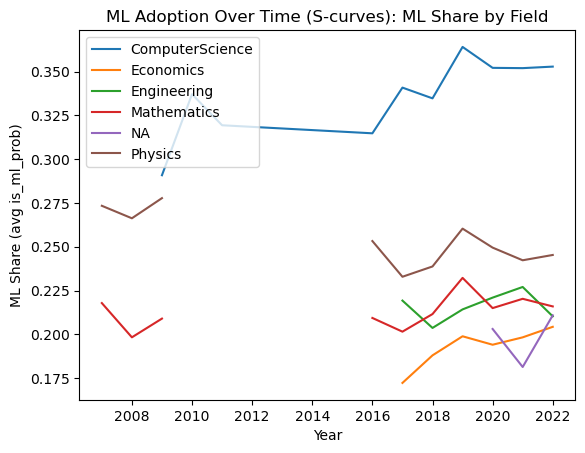

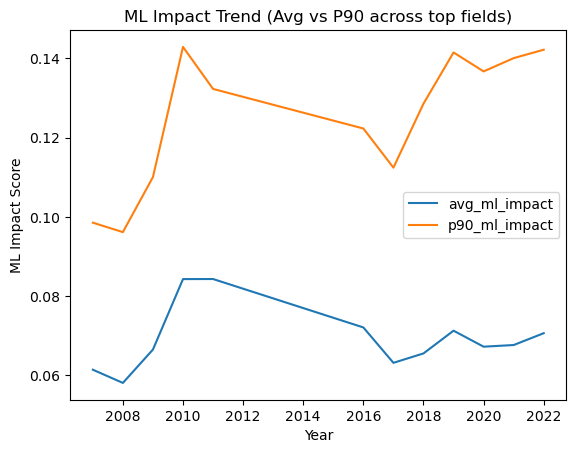

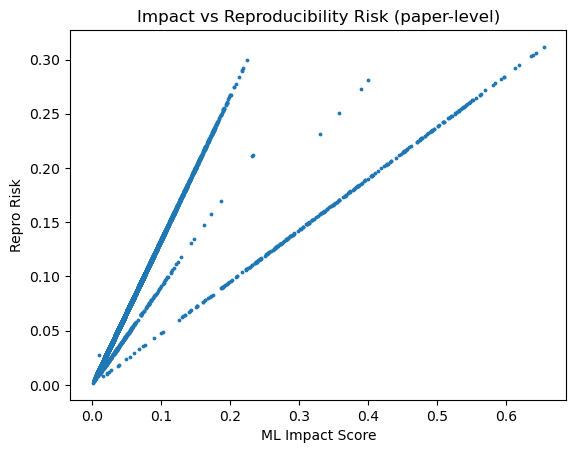

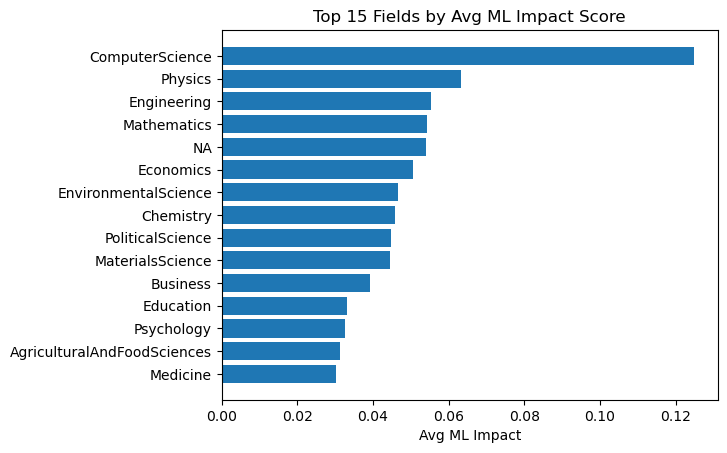

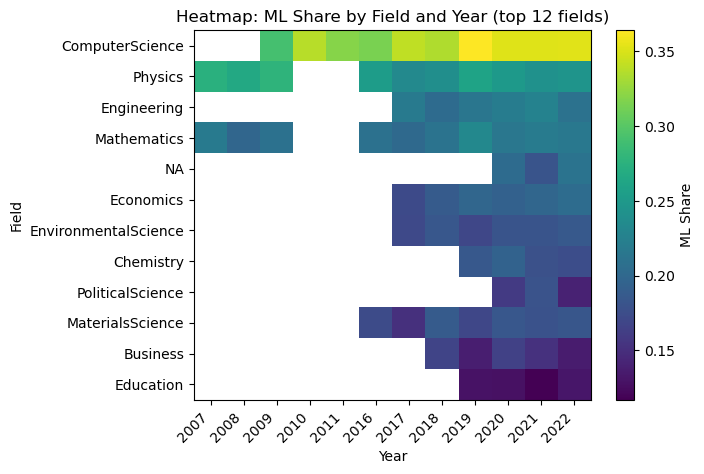

✅ BLOCK 6 COMPLETE (Notebook visuals)


In [25]:
# =========================
# BLOCK 6: NOTEBOOK VISUALS (GOLD -> PLOTS)
# Produces the main plots judges want, directly in notebook.
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gold_dir = cfg.silver_dir.parent / "gold"
paper_fp = gold_dir / "paper_scores.parquet"
fy_fp    = gold_dir / "field_year_metrics.parquet"
field_fp = gold_dir / "field_metrics.parquet"

paper = pd.read_parquet(paper_fp)
fy    = pd.read_parquet(fy_fp)
field = pd.read_parquet(field_fp)

print("Loaded:", paper.shape, fy.shape, field.shape)

# ---------- Plot 1: S-curves (ML share over time) ----------
top_fields = field.sort_values("avg_ml_impact", ascending=False).head(6)["field"].tolist()
tmp = fy[fy["field"].isin(top_fields)].copy()
pivot = tmp.pivot(index="publication_year", columns="field", values="ml_share").sort_index()

plt.figure()
plt.title("ML Adoption Over Time (S-curves): ML Share by Field")
plt.xlabel("Year")
plt.ylabel("ML Share (avg is_ml_prob)")
plt.plot(pivot.index, pivot.values)
plt.legend(pivot.columns, loc="best")
plt.show()

# ---------- Plot 2: Impact trend (avg and p90) ----------
tmp2 = fy[fy["field"].isin(top_fields)].groupby("publication_year").agg(
    avg_ml_impact=("avg_ml_impact","mean"),
    p90_ml_impact=("p90_ml_impact","mean")
).sort_index()

plt.figure()
plt.title("ML Impact Trend (Avg vs P90 across top fields)")
plt.xlabel("Year")
plt.ylabel("ML Impact Score")
plt.plot(tmp2.index, tmp2["avg_ml_impact"].values, label="avg_ml_impact")
plt.plot(tmp2.index, tmp2["p90_ml_impact"].values, label="p90_ml_impact")
plt.legend()
plt.show()

# ---------- Plot 3: Impact vs Repro Risk scatter ----------
# sample for speed
plot_df = paper.sample(min(len(paper), 15000), random_state=42)

plt.figure()
plt.title("Impact vs Reproducibility Risk (paper-level)")
plt.xlabel("ML Impact Score")
plt.ylabel("Repro Risk")
plt.scatter(plot_df["ml_impact_score"].values, plot_df["repro_risk"].values, s=3)
plt.show()

# ---------- Plot 4: Field leaderboard ----------
topN = 15
rank = field.sort_values("avg_ml_impact", ascending=False).head(topN).copy()
rank = rank.sort_values("avg_ml_impact", ascending=True)  # for horizontal bar

plt.figure()
plt.title(f"Top {topN} Fields by Avg ML Impact Score")
plt.xlabel("Avg ML Impact")
plt.barh(rank["field"].values, rank["avg_ml_impact"].values)
plt.show()

# ---------- Plot 5: Heatmap field x year of ML share ----------
# keep top 12 fields for readability
top12 = field.sort_values("avg_ml_impact", ascending=False).head(12)["field"].tolist()
hm = fy[fy["field"].isin(top12)].pivot(index="field", columns="publication_year", values="ml_share")
hm = hm.loc[top12]  # stable order

plt.figure()
plt.title("Heatmap: ML Share by Field and Year (top 12 fields)")
plt.xlabel("Year")
plt.ylabel("Field")
plt.imshow(hm.values, aspect="auto")
plt.yticks(np.arange(len(hm.index)), hm.index)
plt.xticks(np.arange(len(hm.columns)), hm.columns, rotation=45, ha="right")
plt.colorbar(label="ML Share")
plt.show()

print("✅ BLOCK 6 COMPLETE (Notebook visuals)")


BLOCK 6: NOTEBOOK VISUALS (GOLD -> PLOTS)
Loaded:
 papers: (29621, 23)
 field_year: (192, 13)
 fields: (16, 6)


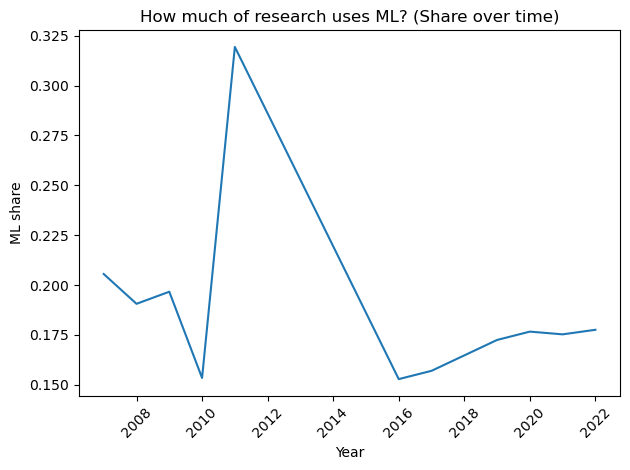

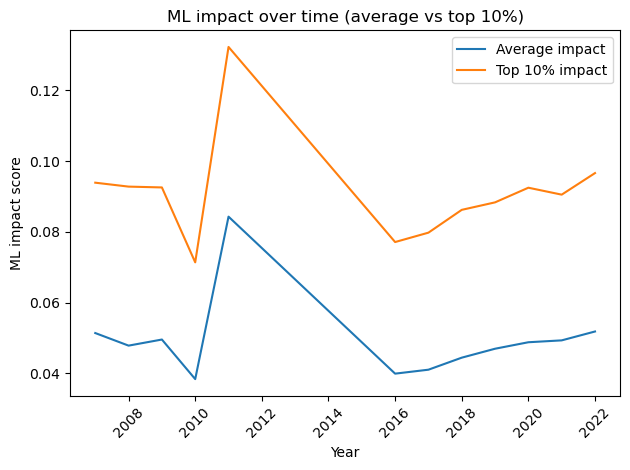

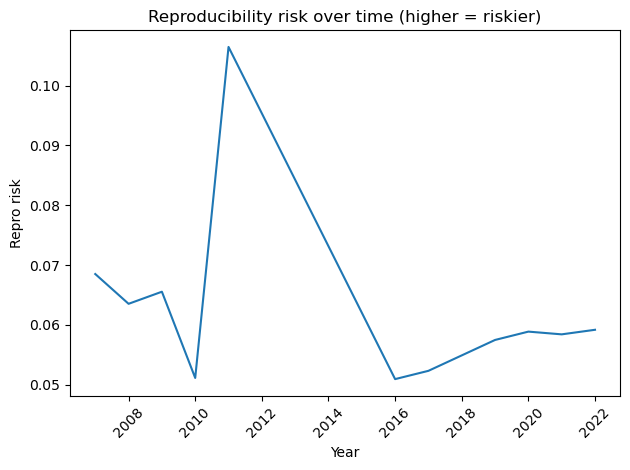

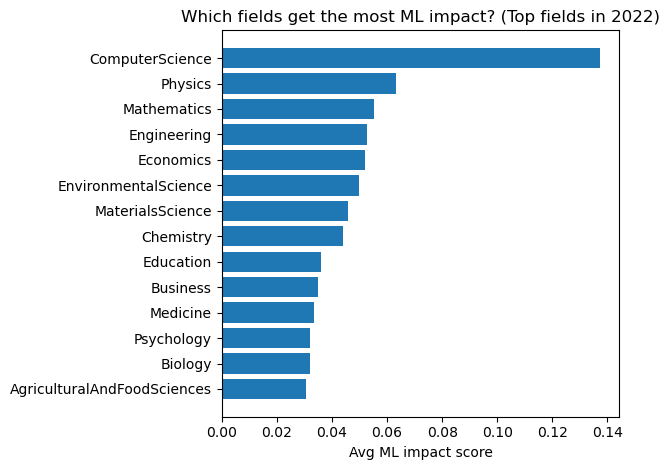

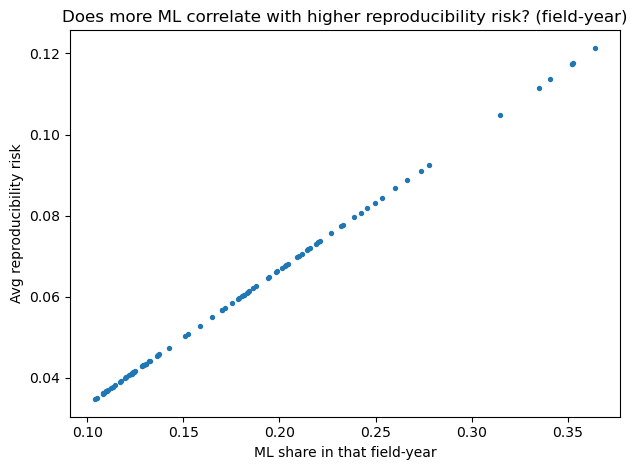

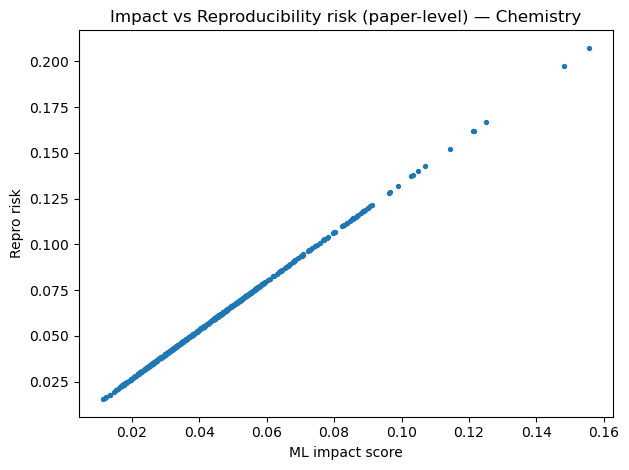

,paper_id,field,publication_year,split,is_ml_prob,ml_impact_score,repro_risk,adoption_pred,impact_pred,repro_pred,matched_term,confidence_score_pred
9905,235826370,ComputerScience,2021,ml_unlabeled,0.934879,0.654415,0.311626,4,1,2,neural network,high
10765,253758731,ComputerScience,2022,ml_unlabeled,0.919363,0.643554,0.306454,4,1,2,neural network,medium
9909,235422421,ComputerScience,2021,ml_unlabeled,0.911764,0.638235,0.303921,4,1,2,neural network,medium
10036,238744214,ComputerScience,2021,ml_unlabeled,0.908385,0.635869,0.302795,4,1,2,neural network,medium
9107,229518843,ComputerScience,2020,ml_unlabeled,0.904460,0.633122,0.301487,4,1,2,neural network,medium
28020,249626177,Physics,2022,ml_unlabeled,0.897310,0.628117,0.299103,4,1,2,neural network,medium
9964,243480284,ComputerScience,2021,ml_unlabeled,0.890719,0.623503,0.296906,4,1,2,neural network,medium
9142,226236863,ComputerScience,2020,ml_unlabeled,0.890488,0.623342,0.296829,4,1,2,neural network,medium
9928,235241071,ComputerScience,2021,ml_unlabeled,0.884257,0.618980,0.294752,4,1,2,neural network,medium
9665,232479463,ComputerScience,2021,ml_unlabeled,0.875961,0.613173,0.291987,4,1,2,neural network,medium


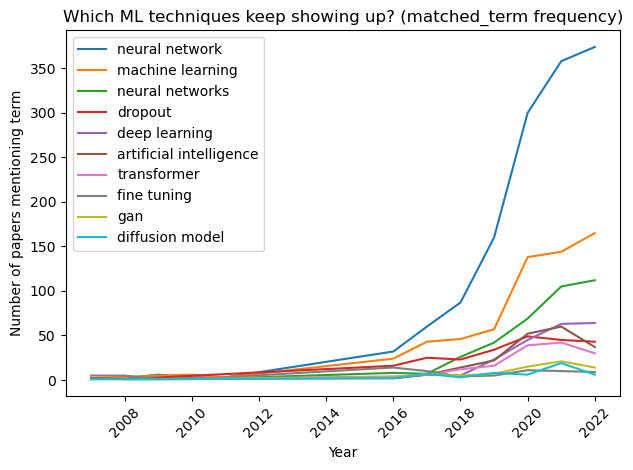

✅ BLOCK 6 COMPLETE


In [27]:
# =========================
# BLOCK 6: NOTEBOOK VISUALS (GOLD METRICS)
# Reads:
#   - gold/paper_scores.parquet
#   - gold/field_year_metrics.parquet
#   - gold/field_metrics.parquet
# Produces:
#   - Clear, non-jargon visuals for judges (year trends, adoption, impact, risk, top examples)
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

print("============================================================")
print("BLOCK 6: NOTEBOOK VISUALS (GOLD -> PLOTS)")
print("============================================================")

gold_dir = cfg.data_dir / "gold" if hasattr(cfg, "data_dir") else (cfg.silver_dir.parent / "gold")
# Based on your run: observatory_run/data/gold
if not gold_dir.exists():
    gold_dir = Path("observatory_run/data/gold")

paper_path = gold_dir / "paper_scores.parquet"
fy_path = gold_dir / "field_year_metrics.parquet"
field_path = gold_dir / "field_metrics.parquet"

papers = pd.read_parquet(paper_path)
field_year = pd.read_parquet(fy_path)
fields = pd.read_parquet(field_path)

print("Loaded:")
print(" papers:", papers.shape)
print(" field_year:", field_year.shape)
print(" fields:", fields.shape)

# ---------- Helpers ----------
def nice_field(x):
    if pd.isna(x) or str(x).strip() == "":
        return "Unknown"
    return str(x)

papers["field"] = papers["field"].map(nice_field)
field_year["field"] = field_year["field"].map(nice_field)
fields["field"] = fields["field"].map(nice_field)

# Some runs may have year missing
if "publication_year" not in papers.columns and "publication_date" in papers.columns:
    papers["publication_year"] = pd.to_numeric(papers["publication_date"], errors="coerce").astype("Int64")

# ---------- 1) Global ML adoption over time ----------
global_year = (
    papers.groupby("publication_year", dropna=False)
    .agg(
        n=("paper_id", "count"),
        ml_share=("is_ml_prob", "mean"),
        avg_impact=("ml_impact_score", "mean"),
        p90_impact=("ml_impact_score", lambda s: np.nanquantile(s, 0.90)),
        avg_risk=("repro_risk", "mean"),
    )
    .reset_index()
    .sort_values("publication_year")
)

plt.figure()
plt.plot(global_year["publication_year"], global_year["ml_share"])
plt.title("How much of research uses ML? (Share over time)")
plt.xlabel("Year")
plt.ylabel("ML share")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 2) Impact trend (avg + p90) ----------
plt.figure()
plt.plot(global_year["publication_year"], global_year["avg_impact"], label="Average impact")
plt.plot(global_year["publication_year"], global_year["p90_impact"], label="Top 10% impact")
plt.title("ML impact over time (average vs top 10%)")
plt.xlabel("Year")
plt.ylabel("ML impact score")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 3) Reproducibility risk trend ----------
plt.figure()
plt.plot(global_year["publication_year"], global_year["avg_risk"])
plt.title("Reproducibility risk over time (higher = riskier)")
plt.xlabel("Year")
plt.ylabel("Repro risk")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 4) Field comparison (latest year snapshot) ----------
latest_year = int(global_year["publication_year"].dropna().max())
fy_latest = field_year[field_year["publication_year"] == latest_year].copy()

# Keep only reasonably-sized fields for readability
fy_latest = fy_latest[fy_latest["n_papers"] >= 80].sort_values("avg_ml_impact", ascending=False).head(15)

plt.figure()
plt.barh(fy_latest["field"], fy_latest["avg_ml_impact"])
plt.title(f"Which fields get the most ML impact? (Top fields in {latest_year})")
plt.xlabel("Avg ML impact score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---------- 5) Adoption vs Risk scatter (field-year points) ----------
# This is the “quality trade-off” chart in plain terms.
sample_fy = field_year[(field_year["n_papers"] >= 80)].copy()

plt.figure()
plt.scatter(sample_fy["ml_share"], sample_fy["avg_repro_risk"], s=8)
plt.title("Does more ML correlate with higher reproducibility risk? (field-year)")
plt.xlabel("ML share in that field-year")
plt.ylabel("Avg reproducibility risk")
plt.tight_layout()
plt.show()

# ---------- 6) Paper-level quadrant (Impact vs Risk) ----------
# Pick a field for a clean view (change as you like)
focus_field = "Chemistry" if "Chemistry" in papers["field"].unique() else papers["field"].value_counts().index[0]
pF = papers[papers["field"] == focus_field].copy()

plt.figure()
plt.scatter(pF["ml_impact_score"], pF["repro_risk"], s=8)
plt.title(f"Impact vs Reproducibility risk (paper-level) — {focus_field}")
plt.xlabel("ML impact score")
plt.ylabel("Repro risk")
plt.tight_layout()
plt.show()

# ---------- 7) Top papers table (human readable) ----------
cols = [c for c in [
    "paper_id","field","publication_year","split",
    "is_ml_prob","ml_impact_score","repro_risk",
    "adoption_pred","impact_pred","repro_pred","matched_term",
    "confidence_score_pred"
] if c in papers.columns]

top = papers.sort_values("ml_impact_score", ascending=False).head(20)[cols]
display(top)

# ---------- 8) Technique trend (matched_term) ----------
# This is your “staying power” proxy right now.
if "matched_term" in papers.columns:
    tech = papers.dropna(subset=["matched_term"]).copy()
    tech["matched_term"] = tech["matched_term"].astype(str).str.lower()

    top_terms = tech["matched_term"].value_counts().head(10).index.tolist()
    tech_top = tech[tech["matched_term"].isin(top_terms)]

    tech_year = (
        tech_top.groupby(["publication_year","matched_term"])
        .size().reset_index(name="n")
        .sort_values(["publication_year","n"], ascending=[True, False])
    )

    # Plot each term line
    plt.figure()
    for term in top_terms:
        sub = tech_year[tech_year["matched_term"] == term]
        plt.plot(sub["publication_year"], sub["n"], label=term)

    plt.title("Which ML techniques keep showing up? (matched_term frequency)")
    plt.xlabel("Year")
    plt.ylabel("Number of papers mentioning term")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("✅ BLOCK 6 COMPLETE")
